# Marginal Cost Curve for Dispatchable Power in Great Britain

In this example we'll estimate the marginal cost curve over the last two months for dispatchable power in Great Britain using data from Electric Insights.

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from moepy import retrieval, eda, lowess

<br>

### Data Loading

We'll start by loading in the necessary data from Electric Insights

In [11]:
%%time

current_dt = pd.Timestamp.now()
start_date = (current_dt-pd.Timedelta(weeks=8)).strftime('%Y-%m-%d %H:%M')
end_date = current_dt.strftime('%Y-%m-%d %H:%M')

renaming_dict = {
    'pumpedStorage' : 'pumped_storage',
    'northernIreland' : 'northern_ireland',
    'windOnshore': 'wind_onshore',
    'windOffshore': 'wind_offshore',
    'prices_ahead' : 'day_ahead_price',
    'prices' : 'imbalance_price',
    'temperatures' : 'temperature',
    'totalInGperkWh' : 'gCO2_per_kWh',
    'totalInTperh' : 'TCO2_per_h'
}

df = retrieval.retrieve_streams_df(start_date, end_date, renaming_dict=renaming_dict)

df.head()

Wall time: 6.02 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-31 14:00:00+00:00,58.29,1,40.51,40.51,3.3,8060.125,209.697037,5.569,1.954,0.499,...,38.437,0.0,4.407341,4.054323,1.000,0.0,2.004,0.200,0.014,0.214
2021-01-31 14:30:00+00:00,54.56,2,40.00,40.00,3.3,8022.315,208.778530,5.569,1.906,0.497,...,38.425,0.0,4.433521,4.121117,1.000,0.0,2.002,0.072,0.060,0.132
2021-01-31 15:00:00+00:00,54.53,3,40.51,40.51,3.3,8274.317,211.722244,5.568,1.933,0.567,...,39.081,0.0,4.314714,4.446700,0.732,0.0,2.004,0.000,0.000,-0.018
2021-01-31 15:30:00+00:00,51.48,4,40.00,40.00,3.3,8456.420,214.788042,5.564,1.898,0.632,...,39.371,0.0,4.264042,4.618492,0.730,0.0,2.004,0.000,0.076,0.076
2021-01-31 16:00:00+00:00,54.11,5,40.52,40.52,3.3,8967.365,220.996254,5.564,1.914,0.791,...,40.577,0.0,4.296072,4.748662,0.666,0.0,2.004,0.064,0.214,0.278


<br>

We'll quickly visualise the relationship between price and dispatchable load for each half-hour period

Text(0, 0.5, 'Price (£/MWh)')

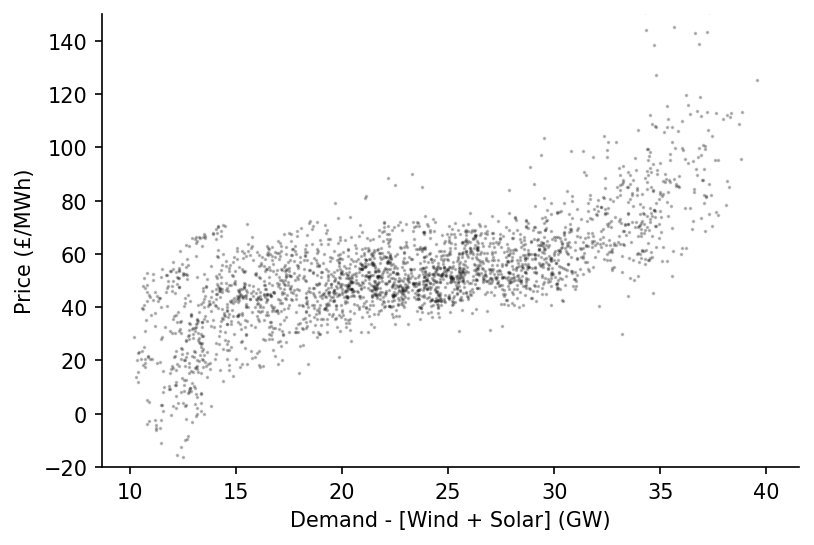

In [6]:
df_model = df[['day_ahead_price', 'demand', 'solar', 'wind']].dropna().astype(float)

s_price = df_model['day_ahead_price']
s_dispatchable = df_model['demand'] - df_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable, s_price, s=0.5, alpha=0.25, color='k')

ax.set_ylim(-20, 150)
eda.hide_spines(ax)
ax.set_xlabel('Demand - [Wind + Solar] (GW)')
ax.set_ylabel('Price (£/MWh)')

<br>

### Marginal Cost Curve Estimation

We're now ready to fit our LOWESS model

<AxesSubplot:>

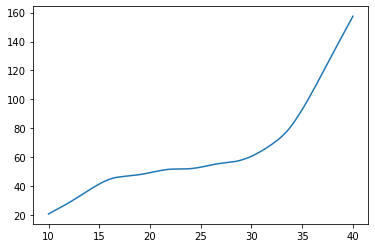

In [9]:
x_pred = np.linspace(10, 40, 301)

y_pred = lowess.lowess_fit_and_predict(s_dispatchable.values, 
                                       s_price.values, 
                                       frac=0.25, 
                                       num_fits=25, 
                                       x_pred=x_pred)

pd.Series(y_pred, index=x_pred).plot()

<br>

We'll then visualise the estimated fit alongside the historical observations

Text(0, 0.5, 'Day-Ahead Price (£/MWh)')

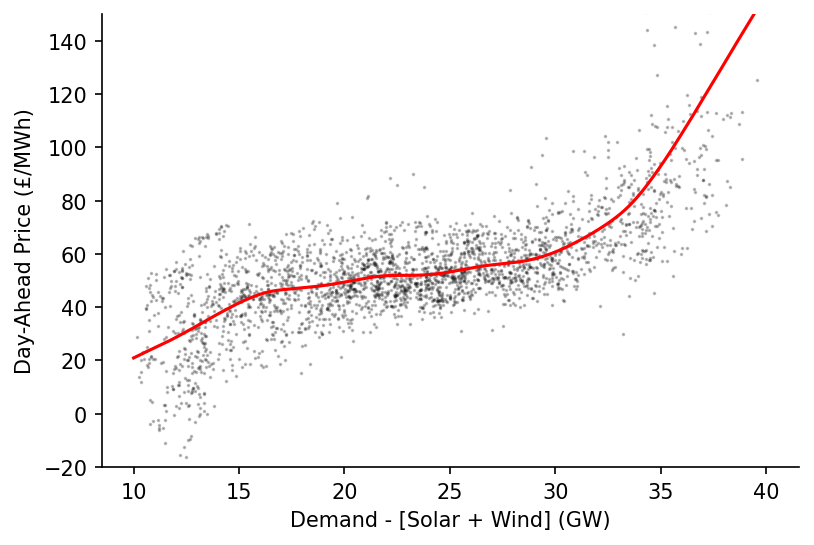

In [10]:
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, linewidth=1.5, color='r')
ax.scatter(s_dispatchable, s_price, color='k', s=0.5, alpha=0.25)

ax.set_ylim(-20, 150)
eda.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (GW)')
ax.set_ylabel('Day-Ahead Price (£/MWh)')